EOF
Top-1024,Sketch:8*28000
Execution time:  55.034 seconds.
Top with 224064 bytes.
CMS Sketch with 896112 bytes.
Total size 1120176 bytes, 
Precision:  0.980
Find:1004
Top_ARE: 0.0835
Top_AAE: 4.2201
Estimate time:  2.338 seconds.


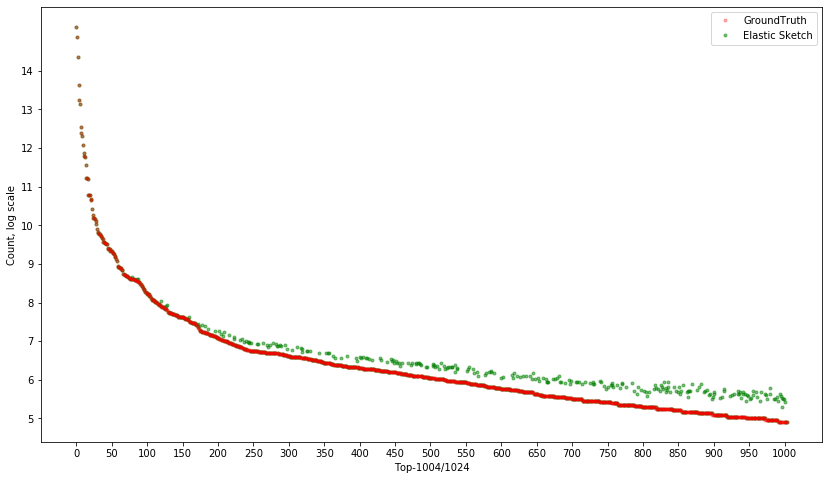

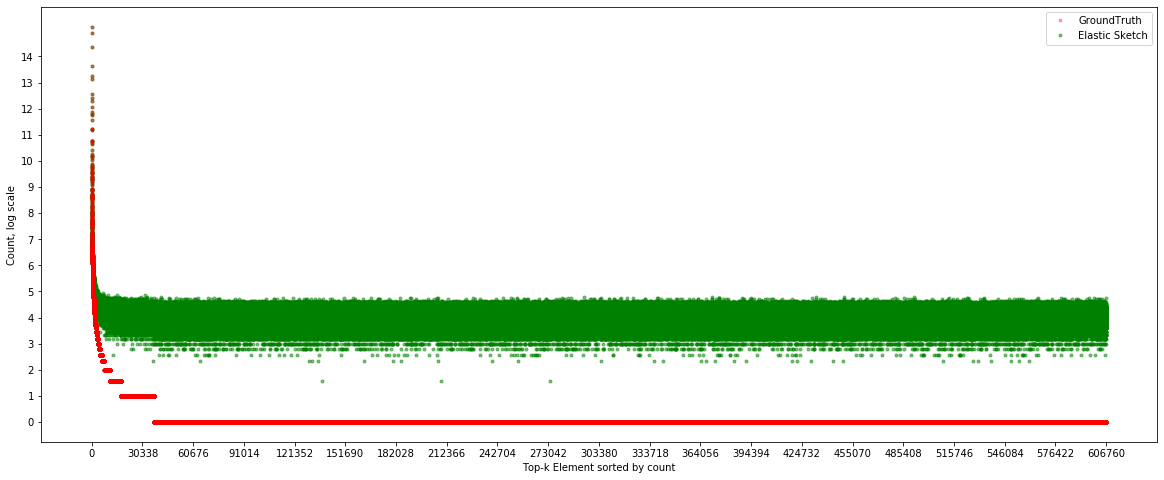

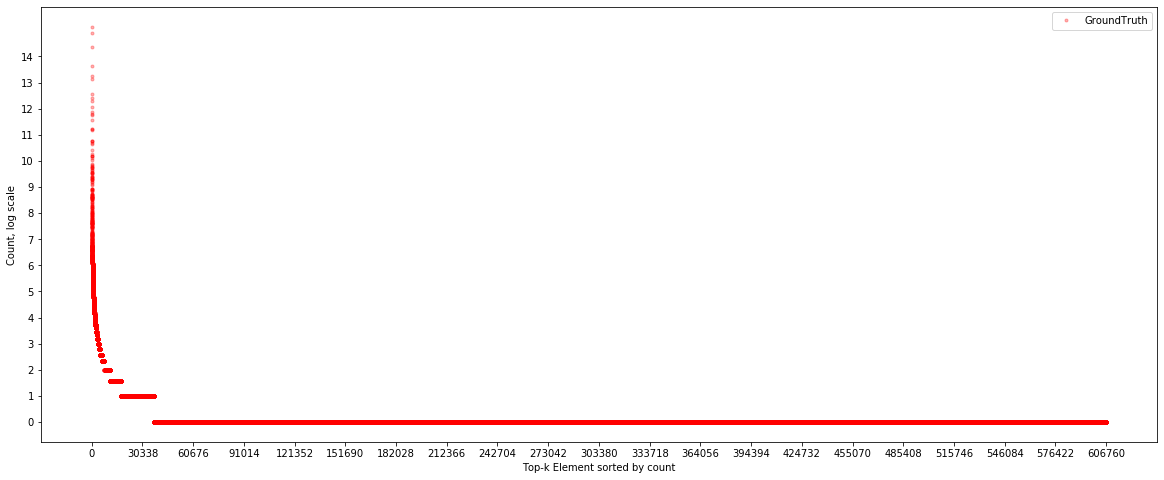

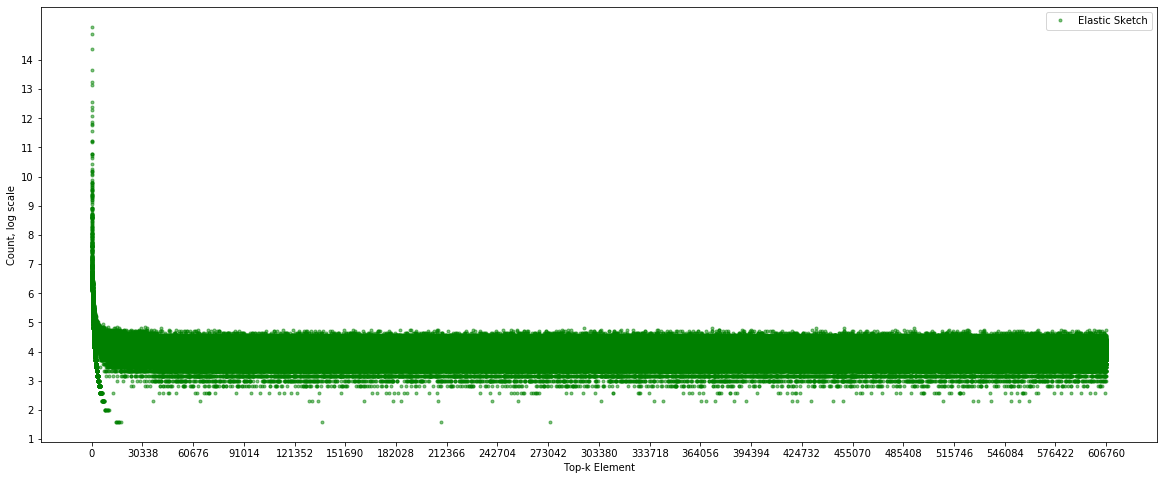

"\nif __name__ == '__main__':\n    main()\n"

In [2]:
# 20210901 rewrite

import os
import sys
import time
sys.path.append("..")
    # 注意這裡
from cms.CountMinSketch import CountMinSketch
from Node import DS
import Tools

import tracemalloc

tracemalloc.start()
    # start track memory usage===========================================================

filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

threshold=4    
w=28000
d=8
size=1024
topk=1024
Tools.Config.Set_default(w,d,size,topk)
cms=CountMinSketch(Tools.Config.width,Tools.Config.depth)    
Top=[None]*Tools.Config.width

#item_count=150
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            #item_count-=1
            index=Tools.Func.position(DS.Tail(e,1),1)
                # one hash only              
            #print("index:{}".format(index))
            if Top[index]==None:
                # bucket is empty
                Top[index]=DS.esNode(e)
            else:
                if Top[index].ID ==e:
                    # hit in Top
                    Top[index].vote_pos+=1
                elif Top[index].ID !=e:
                    # e ollisions with e' at Top
                    Top[index].vote_neg+=1
                    vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                    if vote_threshold<threshold:
                        # less than threshold: send (e,1) to CMS 
                        cms.Add_CMS(DS.Tail(e,1))
                    else:
                        # larger than threshold, evict e' to CMS and set (e,1,T,1)
                        cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                        #cms.Add_CMS(e,Top[index].vote_pos)
                        Top[index]=DS.esNode(e,1,True,1)
    end=time.time()
    snapshot = tracemalloc.take_snapshot()
    top_stats = snapshot.statistics('lineno')
    # stop track memory usage===========================================================
    
    #Top
        # unsorted, can index through hash
    #Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
        # sorted
    #print(Topli)
    #print(cms)
    print("Top-{},Sketch:{}*{}".format(size,d,w))
    print("Execution time:{:8.3f} seconds.".format(end-start))
    print("Top with {} bytes.".format(sys.getsizeof(Top)))
    print("CMS Sketch with {} bytes.".format(sys.getsizeof(cms.sketch)))
    print("Total size {} bytes, ".format(sys.getsizeof(Top)+sys.getsizeof(cms.sketch)))

    # Element-Precision
    Top_dict=dict.fromkeys([i.ID for i in Top],0)
        # set comparison , no sort needed
    tp_set,precision=Tools.Func.Get_precision(gr_path,Top_dict,Tools.Config.topk)
    print("Precision: {:6.3f}".format(precision))

    # set True-Positive Top_dict
    for item in Top:
        if item.ID in tp_set:
            count=Tools.Func.esQuery(item.ID,Top,cms)
            Top_dict[item.ID]=count
        else:
            Top_dict.pop(item.ID,0)

    # Count ARE/AAE
    startx=time.time()
    top_are,top_aae=Tools.Func.Get_ARE_AAE(gr_path,Top_dict,tp_set)
    print("Find:{}".format(len(tp_set)))
    endx=time.time()

    print("Top_ARE: {:6.4f}".format(top_are))
    print("Top_AAE: {:6.4f}".format(top_aae))
    print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
    
    # Top-k compare
    Tools.Func.Plot_topk_compare(gr_path,Top_dict,"Elastic Sketch")
    
    # All element compare
    ground_truth=Tools.Func.Get_ground_truth(gr_path)
    My_result=dict()
    for item in ground_truth:
        # item:ID of e
        My_result[item]=Tools.Func.esQuery(item,Top,cms)
    Tools.Func.Plot_all_compare(ground_truth,My_result,"Elastic Sketch")
    
'''
if __name__ == '__main__':
    main()
'''

In [ ]:
import linecache
import os
import tracemalloc

def display_top(snapshot, key_type='lineno', limit=10):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        print("#%s: %s:%s: %.1f KiB"
              % (index, frame.filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))


display_top(snapshot)

In [ ]:

import numpy as np
import spookyhash
import mmh3
import os
import pandas as pd
import time
import operator
import sys
import re
from probables import (CountMinSketch)

# ==========================data structure==========================
class Node():
    def __init__(self,count=0):
        self.count=count
    def add_count(self,count=1):
        self.count+=count
    def __str__(self):
        return 'count: {}'.format(self.count)
    def __repr__(self):
        return ''

class Head(Node):
    def __init__(self,count=1):
        super().__init__(count)
        self.distinct = hyperloglog.HyperLogLog(0.01)
        self.maxID=''
    def __str__(self):
        return '[total count: {}, distinct: {}, max: {}]'.format(self.count,len(self.distinct),self.maxID)
    def __repr__(self):
        return '[total count: {}, distinct: {}, max: {}]'.format(self.count,len(self.distinct),self.maxID)

class Tail(Node):
    def __init__(self,ID,vote_pos=1,flag=False,vote_neg=0):
        self.ID = str(ID)
        self.vote_pos=vote_pos
        self.flag=flag
        self.vote_neg=vote_neg
        #super().__init__(count)
    def __str__(self):
        return '[{},{},{},{}]'.format(self.ID,self.vote_pos,self.flag,self.vote_neg)
    def __repr__(self):
        return '[{},{},{},{}]'.format(self.ID,self.vote_pos,self.flag,self.vote_neg)
    
# ==========================Tools=========================    
def find(e,element_list):
    # return index of e in element_list
    try:
        index=[ele.ID for ele in element_list].index(e.ID)
    except:
        index=-99
    return index
    
def position(element,size):
    hash1=spookyhash.hash32(bytes(element,encoding='utf-8'))% size
        # input: byte
        # output:unsigned- 32 bit int
    '''
    hash2=mmh3.hash(str(element.ID), signed=False)
    # input: str
    # output: unsigned- 32 bit int
    
    '''
    return hash1

def Query(e):
    index=position(e,size)
    count=0
    if Top[index].ID==e:
        if Top[index].flag==False:
            count=Top[index].vote_pos
        else:
            count=Top[index].vote_pos+cms.check(e)
    else:
        count=cms.check(e)
    return count
    
# ==========================main=========================   

filename='kosarak.dat'
filepath=r"..\dataset\kosarak"

src_data=os.path.join(filepath,filename)
d=128
w=256
size=512
cms = CountMinSketch(width=w, depth=d)
Top=[None]*size
threshold=4

item_count=100
income=0

start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            #item_count-=1
            #income+=1
            index=position(e,size)
            #print("\nread {}-th element:{}".format(income,e))
            if Top[index]==None:
                Top[index]=Tail(e)
            else:
                if Top[index].ID ==e:
                    #print("Hit in Top[{}]".format(index))
                    Top[index].vote_pos+=1
                elif Top[index].ID !=e:
                    #print("Collision at Top[{}]".format(index))
                    Top[index].vote_neg+=1
                    vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                    if vote_threshold<threshold:
                        #print("vote_threshold={}".format(vote_threshold))
                        cms.add(e)
                    else:
                        #print("vote_threshold>{}".format(threshold))
                        cms.add(e,Top[index].vote_pos)
                        Top[index]=Tail(e,1,True,1)
            #print(Top)
end=time.time()
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Total memory {} bytes= ".format(sys.getsizeof(Top)+sys.getsizeof(cms._bins)),end='')
print("Top:{} bytes, Sketch:{} bytes.".format(sys.getsizeof(Top),sys.getsizeof(cms._bins)))

#====================Top to csv=============================
templi=[[i.ID,Query(i.ID)] for i in Top]
df=pd.DataFrame(templi,columns=['ID', 'Count'])
df=df.sort_values(by='Count',ascending=False)
name="Ela_kosarak_Top_Top-"+str(size)+'_'+str(d)+'_'+str(w)+'.csv'
df.to_csv(os.path.join(r'..\result',name),index=False)
    #儲存Top的結果
#====================result compare=============================
gr_path=r"..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
grtruth=pd.read_csv(os.path.join(gr_path,gr_file_name))
Ela_result=pd.read_csv(os.path.join(r'..\result',name))

# precision
gt_set=set(grtruth['Element'][:size])
    # Top-k ID of ground truth
my_set=set(Ela_result['ID'])
tp_set=gt_set & my_set
    # true-positive set
    # &: set 交集運算
precision=len(tp_set)/len(my_set)
print("Precision: {:8.4f}".format(precision))

# ====================ARE/AAE for top and all====================
gt_dict=dict(grtruth.values.tolist())
top_dict=dict(Ela_result.values.tolist())
distinct=len(gt_dict)

all_are=0
all_aae=0
top_are=0
top_aae=0
tp=0
fp=0

startx=time.time()
for item in gt_dict:
    count=Query(str(item))
    all_are+=abs(count-gt_dict[item])/gt_dict[item]
    all_aae+=abs(count-gt_dict[item])
    if item in top_dict:
        # compute ARE/AAE of all elements in Top but not only hit elements
        top_are+=abs(count-gt_dict[item])/gt_dict[item]
        top_aae+=abs(count-gt_dict[item])
        if item in tp_set:
            tp+=1
        else:
            fp+=1
endx=time.time()

top_are=top_are/size
top_aae=top_aae/size
all_are=all_are/distinct
all_aae=all_aae/distinct
print("Find:{}, TP:{}, FP:{}".format(len(tp_set),tp,fp))
print("Top_ARE: {:8.6f}".format(top_are))
print("Top_AAE: {:8.6f}".format(top_aae))
print("all_ARE: {:8.6f}".format(all_are))
print("all_AAE: {:8.6f}".format(all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx))  
